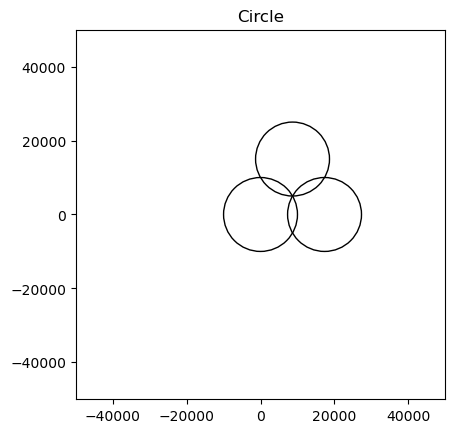

In [1]:
import matplotlib.pyplot as plt
import math
    
dist = math.sqrt(3)*10000
    
figure, axes = plt.subplots()
Drawing_uncolored_circle1 = plt.Circle( (0, 0 ),
                                      10000,
                                      fill = False )
Drawing_uncolored_circle2 = plt.Circle( (dist, 0 ),
                                      10000,
                                      fill = False )
Drawing_uncolored_circle3 = plt.Circle( (dist/2, dist*math.sqrt(3)/2 ),
                                      10000,
                                      fill = False )

 
axes.set_aspect(1 )
axes.add_artist(Drawing_uncolored_circle1)
axes.add_artist(Drawing_uncolored_circle2)
axes.add_artist(Drawing_uncolored_circle3)
axes.set_xlim(-50000, 50000)
axes.set_ylim(-50000, 50000)
plt.title( 'Circle' )
plt.show()

In [2]:
import geopandas

In [3]:
zipfile = '/home/josep/Documents/Landscape Aesths/landscape-aesthetics/NUTS_RG_01M_2021_4326.shp/NUTS_RG_01M_2021_4326.shp'
states = geopandas.read_file(zipfile)

In [8]:
states.query('LEVL_CODE == 0').head()#.loc[0, 'geometry']

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,AL,0,AL,Shqipëria,Shqipëria,0.0,0,0,AL,"MULTIPOLYGON (((19.83100 42.46645, 19.83568 42..."
1,CZ,0,CZ,Česko,Česko,0.0,0,0,CZ,"POLYGON ((14.49122 51.04353, 14.49945 51.04610..."
2,DE,0,DE,Deutschland,Deutschland,0.0,0,0,DE,"MULTIPOLYGON (((10.45444 47.55580, 10.43954 47..."
3,DK,0,DK,Danmark,Danmark,0.0,0,0,DK,"MULTIPOLYGON (((15.19308 55.32014, 15.19056 55..."
4,CY,0,CY,Kýpros,Κύπρος,0.0,0,0,CY,"MULTIPOLYGON (((34.60609 35.70767, 34.60060 35..."


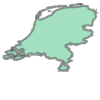

In [9]:
states.loc[34, 'geometry']

In [10]:
import shapely
point = shapely.geometry.Point(14.16, 50.03)

In [11]:
states.loc[1, 'geometry'].contains(point)

True

In [12]:
cr = states.loc[1, 'geometry']

In [13]:
cr.bounds

(12.092099, 48.551826, 18.858903, 51.054699)

In [14]:
import numpy as np
np.array([4, 3, 2, 1])[[True, False, False, True]]

array([4, 1])

In [15]:
import tqdm

In [16]:
x = []
y = []
mask = []
for i in tqdm.tqdm(np.arange(cr.bounds[0], cr.bounds[2], 0.01)):
    for j in np.arange(cr.bounds[1], cr.bounds[3], 0.01):
        x.append(i)
        y.append(j)
        mask.append(states.loc[1, 'geometry'].contains(shapely.geometry.Point(i, j)))

100%|█████████████████████████████████████████| 677/677 [01:00<00:00, 11.13it/s]


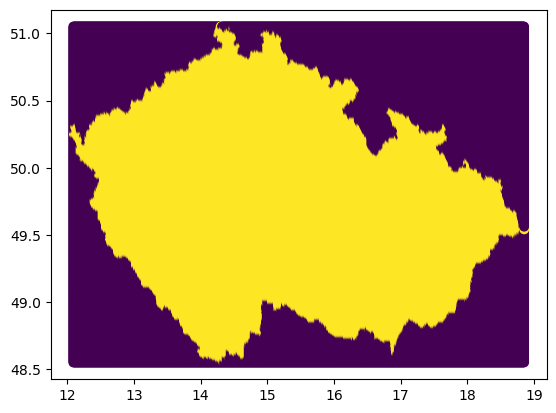

In [18]:
plt.scatter(x, y, c = mask)
plt.show()

In [31]:
from geopy import distance
#help(distance.Geodesic)

In [37]:
point.bounds

(3.359359, 50.750964, 3.359359, 50.750964)

In [48]:
shape.bounds

(3.359359, 50.750964, 7.225861, 53.555472)

In [49]:
distance.distance(kilometers = 10).destination((lon, lat), bearing = 0)

Point(3.4497927448306713, 50.750964, 0.0)

In [44]:
y

50.840949122157824

In [22]:
shape.bounds

(3.359359, 50.750964, 7.225861, 53.555472)

In [45]:
help(distance.distance(kilometers = 10).destination)

Help on method destination in module geopy.distance:

destination(point, bearing, distance=None) method of geopy.distance.geodesic instance
    Calculate destination point using a starting point, bearing
    and a distance. This method works for non-abstract distances only.
    
    Example: a point 10 miles east from ``(34, 148)``::
    
        >>> import geopy.distance
        >>> geopy.distance.distance(miles=10).destination((34, 148), bearing=90)
        Point(33.99987666492774, 148.17419994321995, 0.0)
    
    :param point: Starting point.
    :type point: :class:`geopy.point.Point`, list or tuple of ``(latitude,
        longitude)``, or string as ``"%(latitude)s, %(longitude)s"``.
    
    :param float bearing: Bearing in degrees: 0 -- North, 90 -- East,
        180 -- South, 270 or -90 -- West.
    
    :param distance: Distance, can be used to override
        this instance::
    
            >>> from geopy.distance import distance, Distance
            >>> distance(miles=10)

In [55]:
shape.bounds

(3.359359, 50.750964, 7.225861, 53.555472)

In [104]:
shape.bounds[:2]

(3.359359, 50.750964)

In [138]:
distance.distance(meters = 10).destination((lon, lat), bearing = 0)

Point(3.359445272483205, 53.63048790905025, 0.0)

In [117]:
lon, lat = shape.bounds[:2]

In [118]:
lat

50.750964

In [119]:
shape.bounds[3]

53.555472

In [283]:
help(distance.geodesic(meters = radius*3**0.5).destination)

Help on method destination in module geopy.distance:

destination(point, bearing, distance=None) method of geopy.distance.geodesic instance
    Calculate destination point using a starting point, bearing
    and a distance. This method works for non-abstract distances only.
    
    Example: a point 10 miles east from ``(34, 148)``::
    
        >>> import geopy.distance
        >>> geopy.distance.distance(miles=10).destination((34, 148), bearing=90)
        Point(33.99987666492774, 148.17419994321995, 0.0)
    
    :param point: Starting point.
    :type point: :class:`geopy.point.Point`, list or tuple of ``(latitude,
        longitude)``, or string as ``"%(latitude)s, %(longitude)s"``.
    
    :param float bearing: Bearing in degrees: 0 -- North, 90 -- East,
        180 -- South, 270 or -90 -- West.
    
    :param distance: Distance, can be used to override
        this instance::
    
            >>> from geopy.distance import distance, Distance
            >>> distance(miles=10)

In [521]:
def generate_circle(point):
    lon_centre, lat_centre = point.bounds[:2]
    naive_circle = point.buffer(1)
    lon_max, lat_max = naive_circle.bounds[2:]
    
    lat_scaling_factor = distance.geodesic((lat_centre, lon_centre), (lat_max, lon_centre)).km
    
    correct_lat_circle = point.buffer(10/lat_scaling_factor)
    
    lon_scaling_factor = distance.geodesic((lat_centre, lon_centre), (lat_centre, lon_max)).km
    #print(lon_scaling_factor)
    correct_circle = shapely.affinity.scale(correct_lat_circle, 111.25/lon_scaling_factor, 1) # why 111.25? lmao
    return correct_circle

In [525]:
use_circles = True
shape = states.loc[34, 'geometry']
lon, lat = shape.bounds[:2]
lons, lats, mask = [], [], []
radius = 10000
indent = True
while lat < shape.bounds[3]:
    while lon < shape.bounds[2]:
        point = shapely.geometry.Point(lon, lat)
        lats.append(lat); lons.append(lon)
        if use_circles:
            mask.append(shape.intersects(generate_circle(point)))
        else:
            mask.append(shape.contains(point))
        
        lat, lon, _ = distance.geodesic(meters = radius*3**0.5).destination((lat, lon), bearing = 90)
    
    lon = shape.bounds[0]
    if indent:
        lat, lon, _ = distance.geodesic(meters = 0.5*radius*3**0.5).destination((lat, lon), bearing = 90)
    lat, lon, _ = distance.distance(meters = 3*radius/2).destination((lat, lon), bearing = 0)
    
    indent = not indent

In [526]:
np.array(mask).sum()

208

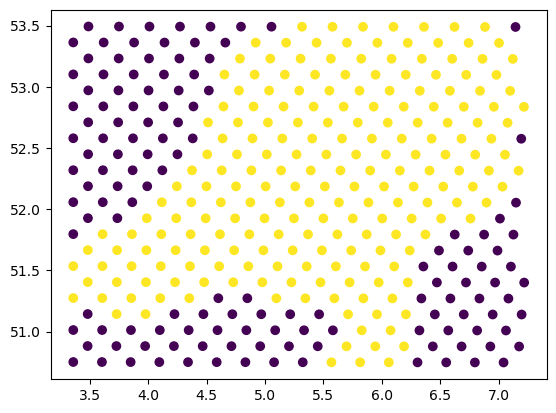

In [527]:
plt.scatter(lons, lats, c = mask)
plt.show()

In [331]:
lon, lat = shape.bounds[0], shape.bounds[1]

In [332]:
distance.geodesic(
    (lats[1], lons[1]),
    (lats[2], lons[2])).km

17.320508075688757

In [333]:
radius

10000

In [384]:
point.bounds[:2]

(7.142798368961795, 53.48874598541068)

In [346]:
point.buffer(1).bounds

(6.142798368961795, 52.48874598541068, 8.142798368961795, 54.48874598541068)

In [395]:
distance.geodesic(
    (point.bounds[1], point.bounds[0]),
    (point.buffer(10/111.28605018894305).bounds[1], point.bounds[0])).km

10.000768972109721

In [383]:
str(point)

'POINT (7.142798368961795 53.48874598541068)'

In [522]:
distance.geodesic(
    (point.bounds[1], point.bounds[0]),
    (point.bounds[1], generate_circle(point).bounds[0])).km

9.99515805074404

In [523]:
for lat, lon in zip(lats, lons):
    point = shapely.geometry.Point(lon, lat)
    print(
        distance.geodesic(
        (point.bounds[1], point.bounds[0]),
        (generate_circle(point).bounds[1], point.bounds[0])).km,

        distance.geodesic(
        (point.bounds[1], point.bounds[0]),
        (point.bounds[1], generate_circle(point).bounds[0])).km
    )

9.99906246063526 9.999798439847886
9.99906245884688 9.999798882945479
9.99906245705924 9.999799326040122
9.999062455271275 9.999799769131487
9.999062453481212 9.999800212219505
9.999062451694362 9.999800655304723
9.999062449906127 9.999801098386424
9.999062448117213 9.999801541465107
9.999062446329033 9.999801984540689
9.999062444541234 9.99980242761316
9.999062442753466 9.999802870682313
9.999062440965723 9.999803313748446
9.999062439176951 9.999803756811358
9.999062437390327 9.999804199871095
9.999062435602314 9.999804642927582
9.999062433816453 9.999805085981238
9.999063375309936 9.99957439445357
9.999063373473335 9.999574839147929
9.999063371637126 9.999575283839038
9.99906336980201 9.999575728527018
9.999063367967281 9.999576173211928
9.999063366131168 9.999576617893489
9.999063364295084 9.99957706257189
9.999063362460806 9.999577507247283
9.999063360625142 9.999577951919365
9.999063358791277 9.999578396588356
9.999063356955679 9.999578841254316
9.999063355120466 9.999579285916786

In [379]:
print(shapely.affinity.scale(point.buffer(1/11.119949977394795), 1, 0.5).centroid)
print(shapely.affinity.scale(point.buffer(1/11.119949977394795), 1, 0.5).bounds)

POINT (7.142798368961794 53.48874598541066)
(7.052869906870432, 53.443781754365, 7.232726831053158, 53.53371021645636)


In [334]:
lons[18:]

[3.974285142040876,
 4.220394726774347,
 4.466502944894011,
 4.712609796432698,
 4.9587152814232365,
 5.204819399898454,
 5.450922151891177,
 5.69702353743423,
 5.943123556560437,
 6.18922220930262,
 6.435319495693601,
 6.681415415766199,
 6.927509969553234,
 7.173603157087523,
 3.359359,
 3.6061623308503523,
 3.852964278366971,
 4.099764842583302,
 4.346564023532793,
 4.593361821248889,
 4.840158235765034,
 5.086953267114669,
 5.333746915331237,
 5.580539180448177,
 5.827330062498929,
 6.074119561516929,
 6.3209076775356134,
 6.567694410588419,
 6.814479760708778,
 7.061263727930124,
 3.4827499464672704,
 3.730249017156308,
 3.9777466876346588,
 4.2252429579363975,
 4.472737828095599,
 4.720231298146335,
 4.9677233681226785,
 5.2152140380587,
 5.462703307988467,
 5.710191177946049,
 5.957677647965512,
 6.205162718080921,
 6.4526463883263405,
 6.700128658735833,
 6.9476095293434605,
 7.195089000183283,
 3.359359,
 3.6075592800266736,
 3.855758142722296,
 4.1039555881215835,
 4.35215161

In [335]:
distance.geodesic(
    (lons[0], lats[0]),
    (lons[18], lats[18])).km

69.51740351639036

In [336]:
lons[1], lats[1]

(3.6047856706217196, 50.75070576064683)

In [337]:
lons[26], lats[26]

(5.943123556560437, 50.87901150781152)

In [338]:
import folium


In [528]:
map = folium.Map([shape.centroid.bounds[1], shape.centroid.bounds[0], ], zoom_start=8)
for lat, lon, is_in in zip(lats, lons, mask):
    if is_in:
        folium.vector_layers.CircleMarker(
            location=[lat, lon],
            radius=26,
            color='#3186cc',
            fill=False    
        ).add_to(map)

map # ATTENTION: circle radia are approximated

In [100]:
lon, lat, _ = distance.distance(kilometers = 10).destination((lon, lat), bearing = 0)
print(lon, lat)

4.082823886074385 50.750964


In [60]:
lons[0], lons[-1]

(3.359359, 3.076471778425379)

In [61]:
lats[0], lats[-1]

(50.750964, -39.41251476792637)

In [37]:
distance.distance(kilometers = 10).destination((34, 148), bearing = 90)

Point(33.999952380026, 148.10824289043094, 0.0)

In [35]:
help(distance.distance.destination)

Help on function destination in module geopy.distance:

destination(self, point, bearing, distance=None)
    Calculate destination point using a starting point, bearing
    and a distance. This method works for non-abstract distances only.
    
    Example: a point 10 miles east from ``(34, 148)``::
    
        >>> import geopy.distance
        >>> geopy.distance.distance(miles=10).destination((34, 148), bearing=90)
        Point(33.99987666492774, 148.17419994321995, 0.0)
    
    :param point: Starting point.
    :type point: :class:`geopy.point.Point`, list or tuple of ``(latitude,
        longitude)``, or string as ``"%(latitude)s, %(longitude)s"``.
    
    :param float bearing: Bearing in degrees: 0 -- North, 90 -- East,
        180 -- South, 270 or -90 -- West.
    
    :param distance: Distance, can be used to override
        this instance::
    
            >>> from geopy.distance import distance, Distance
            >>> distance(miles=10).destination((34, 148), bearing=90,

In [10]:
c = cr.centroid

In [11]:
c.bounds

(15.33142180547522, 49.73904752197919, 15.33142180547522, 49.73904752197919)

In [120]:
point.bounds

(50.03, 14.16, 50.03, 14.16)